In [ ]:
# Francisco Dominguez Mateos
# 02/07/2020
# SIREN
# from:https://www.youtube.com/watch?v=Q5g3p9Zwjrk
#      https://vsitzmann.github.io/siren/

In [1]:
import time
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Dense, Relu, LogSoftmax
from jax.experimental import optimizers

import matplotlib.pyplot as plt
import cv2

In [2]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

In [127]:
def Siren(s=[1000]*5):
    def init_fun(key,input_shape):
        """ Initialize the weights of all layers of a linear layer network """
        sizes=[input_shape[-1]]+s
        print(sizes,len(sizes))
        keys = random.split(key, len(sizes))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, rng):
            scale=np.sqrt(6.0/float(m))
            w_key, b_key = random.split(key)
            return scale * random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        # actually they are pairs plus the random key
        pairs=zip(sizes[:-1], sizes[1:], keys)
        params=[initialize_layer(m, n, k) for m, n, k in pairs]
        params[0]=params[0][0]*30.0,params[0][1]
        return params
    def apply_fun(params, inputs, **kwargs):
        """ Compute the forward pass for each example individually """
        activations = inputs
        # Loop over the Siren hidden layers
        for w, b in params:
            linear = np.dot(w,activations)+b
            activations=np.sin(linear)
        return activations
    return init_fun, apply_fun

In [176]:
init,net=Siren([200]*7+[3])
input_shape=(-1,2)
params=init(rng,input_shape)
print(len(params))
for l in params:
    print(l[0].shape,l[1].shape)

[2, 200, 200, 200, 200, 200, 200, 200, 3] 9
8
(200, 2) (200,)
(200, 200) (200,)
(200, 200) (200,)
(200, 200) (200,)
(200, 200) (200,)
(200, 200) (200,)
(200, 200) (200,)
(3, 200) (3,)


In [177]:
# Make a batched version of the `net` function
batch_net = vmap(net, in_axes=(None, 0), out_axes=0)

In [178]:
X, Y = np.meshgrid(range(225),range(225))
xy=np.dstack((Y,X))
input_ordered=np.reshape(xy,(-1,2))
print(input_ordered.shape)

(50625, 2)


In [179]:
def getInputOrdered(size):
    width=size[1]
    height=size[0]
    X, Y = np.meshgrid(range(height),range(width))
    X=X/height*2.0-1.0
    Y=Y/width *2.0-1.0
    xy=np.dstack((Y,X))
    input_ordered=np.reshape(xy,(-1,2))
    return input_ordered

def build_img(size):
    width=size[1]
    height=size[0]
    input_ordered=getInputOrdered(size)
    print(input_ordered.shape)

    img=batch_net(params,input_ordered)
    print(img.shape)
    return np.reshape(img,(height,width,3))

(50625, 2)
(50625, 3)
1.0 -1.0


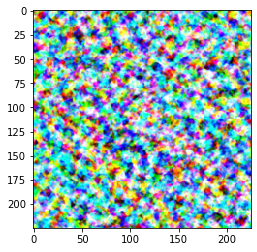

In [180]:
input_ordered=getInputOrdered((225,225))
img=build_img((225,225))
print(np.max(img),np.min(img))
plt.imshow((img+1.0)/2.0)

(225, 225, 3)
(50625, 3) 1.0 -1.0


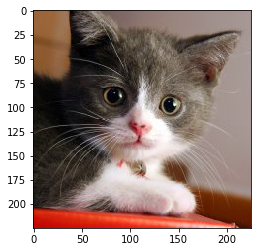

In [181]:
img_bgr=cv2.imread('cat.jpg')
img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img=img_rgb/255.0*2.0-1.0
plt.imshow((img+1.0)/2.0)
#plt.imshow(img_rgb)
print(img.shape)
img_flat=np.reshape(img,(-1,3))
print(img_flat.shape,np.max(img_flat),np.min(img_flat))

In [182]:
@jit
def mse_loss(params, inputs, targets):
    """ Calculate the Mean Squared Error Prediction Loss. """
    preds = batch_net(params, inputs)
    return np.mean((preds - targets)**2)
@jit
def accuracy(params,inputs,targets):
    return mse_loss(params,inputs,targets)
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [183]:
print(input_ordered.shape)
print(img_flat.shape)
mse_loss(params,input_ordered,img_flat)

(50625, 2)
(50625, 3)


DeviceArray(0.79843134, dtype=float32)

In [184]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [185]:
num_epochs = 1000
num_classes = 10

In [186]:
def run_training_loop(num_epochs, opt_state):
    global params
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params,input_ordered,img_flat)
    test_acc  = accuracy(params,input_ordered,img_flat)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss = update(params, input_ordered,img_flat, opt_state)
        train_loss.append(loss)

        train_acc = accuracy(params,input_ordered,img_flat)
        test_acc = accuracy(params,input_ordered,img_flat)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        if(epoch %100 ==0):
            epoch_time = time.time() - start_time
            print("Epoch {} | T: {:0.3f} | Train A: {:0.4f} | Test A: {:0.4f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
    return opt_state, train_loss, log_acc_train, log_acc_test

In [187]:
opt_state, train_loss, train_log, test_log =run_training_loop(num_epochs,opt_state)

Epoch 1 | T: 2.393 | Train A: 0.5725 | Test A: 0.5725
Epoch 101 | T: 0.056 | Train A: 0.0063 | Test A: 0.0063
Epoch 201 | T: 0.057 | Train A: 0.0037 | Test A: 0.0037
Epoch 301 | T: 0.057 | Train A: 0.0028 | Test A: 0.0028
Epoch 401 | T: 0.057 | Train A: 0.0022 | Test A: 0.0022
Epoch 501 | T: 0.057 | Train A: 0.0019 | Test A: 0.0019
Epoch 601 | T: 0.057 | Train A: 0.0016 | Test A: 0.0016
Epoch 701 | T: 0.057 | Train A: 0.0014 | Test A: 0.0014
Epoch 801 | T: 0.058 | Train A: 0.0013 | Test A: 0.0013
Epoch 901 | T: 0.057 | Train A: 0.0011 | Test A: 0.0011


(50625, 2)
(50625, 3)
0.9999999 0.0


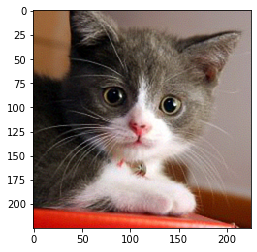

In [188]:
img=build_img((225,225))
print(np.max((img+1.0)/2.0),np.min((img+1.0)/2.0))
plt.imshow((img+1.0)/2.0)